In this vignette we will use the **TCGAbiolinks** to access TCGA metadata and explore estabilished classification of molecular subtypes in the TCGA Acute Myeloid Leukemia samples.

## Step 1: Set-up

1. Download and unzip AML dataset from: http://acgt.cs.tau.ac.il/multi_omic_benchmark/download.html (Rappoport & Shamir, 2019). 
2. Install required packages (see *set_up.R* for instructions if needed)

In [1]:
# Attach required packages
library(tidyverse)
library(ggalluvial)
library(TCGAbiolinks)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [23]:
# Specify path to directory with downloaded data
data_dir_path = "../aml"
stopifnot(file.exists(file.path(data_dir_path, 'exp')) & file.exists(file.path(data_dir_path, 'methy')) & 
          file.exists(file.path(data_dir_path, 'mirna')))

In [3]:
# Inrease plot resolution in this notebook
options(repr.plot.res=150)

## Step 2: Fetch TCGA metadata

In [4]:
pancancer_subtypes <- PanCancerAtlas_subtypes() %>%
    as_tibble() %>%
    filter(cancer.type == "AML")
head(pancancer_subtypes)

pan.samplesID,cancer.type,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
TCGA-AB-2802,AML,NA,NA,NA,3,NA,NA,NA,AML.NA
TCGA-AB-2803,AML,3,NA,NA,5,NA,NA,NA,AML.3
TCGA-AB-2805,AML,5,NA,NA,1,NA,NA,NA,AML.5
TCGA-AB-2806,AML,4,NA,NA,4,NA,NA,NA,AML.4
TCGA-AB-2807,AML,6,NA,NA,4,NA,NA,NA,AML.6
TCGA-AB-2808,AML,5,NA,NA,4,NA,NA,NA,AML.5


In [5]:
pancancer_subtypes %>%
    select(-cancer.type) %>%
    gather(classification, subtype, -pan.samplesID) %>%
    group_by(classification, subtype) %>%
    summarise(nsamples=n())

`summarise()` has grouped output by 'classification'. You can override using the `.groups` argument.



classification,subtype,nsamples
<chr>,<chr>,<int>
Subtype_CNA,NA,187
Subtype_DNAmeth,NA,187
Subtype_Integrative,NA,187
Subtype_miRNA,1,14
Subtype_miRNA,2,40
Subtype_miRNA,3,50
Subtype_miRNA,4,65
Subtype_miRNA,5,18
Subtype_mRNA,1,14


More information about TCGA molecular subtypes can be found [here](https://bioconductor.org/packages/release/bioc/vignettes/TCGAbiolinks/inst/doc/subtypes.html). Here we have available two classifications based on miRNA and mRNA data respectively. Subtype_Selected refers to most commonly used classification.

In [6]:
subtypes <- pancancer_subtypes %>% select(pan.samplesID, Subtype_miRNA, Subtype_mRNA, Subtype_Selected)
head(subtypes)

pan.samplesID,Subtype_miRNA,Subtype_mRNA,Subtype_Selected
<chr>,<chr>,<chr>,<chr>
TCGA-AB-2802,3,NA,AML.NA
TCGA-AB-2803,5,3,AML.3
TCGA-AB-2805,1,5,AML.5
TCGA-AB-2806,4,4,AML.4
TCGA-AB-2807,4,6,AML.6
TCGA-AB-2808,4,5,AML.5


In [24]:
# Samples in our dataset
samples_exp <- read.table(file.path(data_dir_path, 'exp')) %>% colnames()
samples_methy <- read.table(file.path(data_dir_path, 'methy')) %>% colnames()
samples_mirna <- read.table(file.path(data_dir_path, 'mirna')) %>% colnames()

In [26]:
# unify sample notation to TCGA-XY-ABCD
samples <- 
    tibble(sample_codes = c(samples_exp, samples_methy, samples_mirna)) %>%
    distinct() %>%
    separate(sample_codes, c('a', 'b', 'c'), sep="\\.", extra = "drop", remove=FALSE) %>%
    unite(c(a, b, c), col='samples', sep="-") %>% 
    left_join(subtypes, by=c('samples'='pan.samplesID'))
head(samples)

sample_codes,samples,Subtype_miRNA,Subtype_mRNA,Subtype_Selected
<chr>,<chr>,<chr>,<chr>,<chr>
TCGA.AB.2803.03,TCGA-AB-2803,5,3,AML.3
TCGA.AB.2805.03,TCGA-AB-2805,1,5,AML.5
TCGA.AB.2806.03,TCGA-AB-2806,4,4,AML.4
TCGA.AB.2807.03,TCGA-AB-2807,4,6,AML.6
TCGA.AB.2808.03,TCGA-AB-2808,4,5,AML.5
TCGA.AB.2810.03,TCGA-AB-2810,3,1,AML.1


## Step 3 Compare available classifications

In [27]:
data <- samples %>% 
    mutate(Subtype_miRNA=ifelse(is.na(Subtype_miRNA), 'miRNA.NA', Subtype_miRNA), # distinct groups for plotting 
           Subtype_mRNA=ifelse(is.na(Subtype_mRNA), 'mRNA.NA', Subtype_mRNA),
           Subtype_Selected=ifelse(is.na(Subtype_Selected), 'AML.NA', Subtype_Selected))
dim(data)

[1] 197   5

`summarise()` has grouped output by 'Subtype_miRNA', 'Subtype_mRNA'. You can override using the `.groups` argument.

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


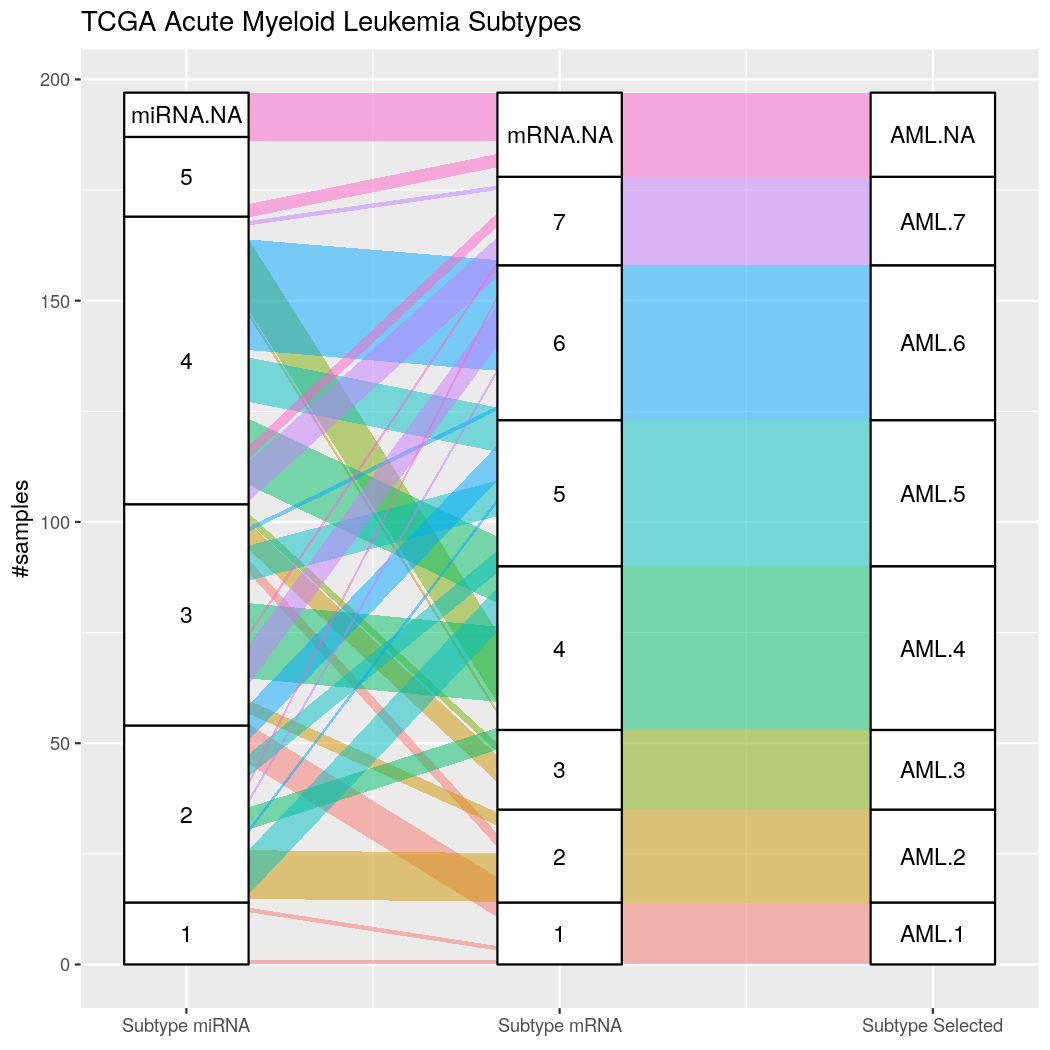

In [32]:
data %>%
    group_by(Subtype_miRNA, Subtype_mRNA, Subtype_Selected) %>%
    summarise(nsamples=n()) %>%
    ggplot(aes(y=nsamples, axis1=Subtype_miRNA, axis2=Subtype_mRNA, 
                      axis3=Subtype_Selected)) +
      geom_alluvium(aes(fill=Subtype_Selected), width = 0, knot.pos = 0, reverse = FALSE) +
      guides(fill = FALSE) +
      geom_stratum(width = 1/3, reverse = FALSE) +
      geom_text(stat = "stratum", aes(label = after_stat(stratum)),
                reverse = FALSE) +
      scale_x_continuous(breaks = 1:3, labels = c("Subtype miRNA", "Subtype mRNA", "Subtype Selected")) +
      labs(title="TCGA Acute Myeloid Leukemia Subtypes", y="#samples")

In [40]:
# change "AML.NA" subtype into NA
samples <- samples %>% mutate(Subtype_Selected = ifelse(grepl("NA", Subtype_Selected), NA, Subtype_Selected))

In [46]:
# save sample labels into tab delimited files
write_tsv(samples, file = 'AML_subtypes.tsv')

labels_mRNA <- samples %>% 
    select(samples, Subtype_mRNA) %>%
    rename(sample=samples, label=Subtype_mRNA) 
write_tsv(labels_mRNA, file = 'AML_subtypes_mRNA.tsv')

labels_miRNA <- samples %>% 
    select(samples, Subtype_miRNA) %>%
    rename(sample=samples, label=Subtype_miRNA) 
write_tsv(labels_miRNA, file = 'AML_subtypes_mRNA.tsv')